**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [3]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Vanishing/Exploding Gradients Problem

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


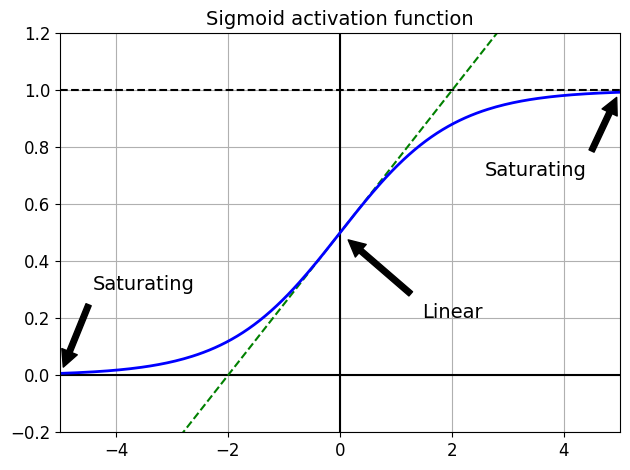

In [5]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [7]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [8]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [9]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


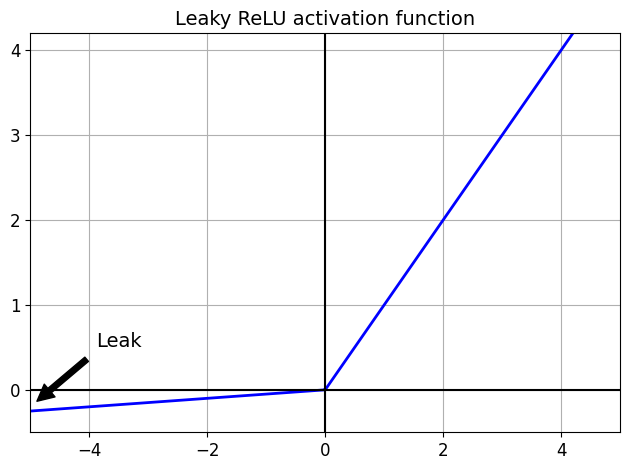

In [10]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [11]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [12]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.6907 - accuracy: 0.7704 - val_loss: 0.5162 - val_accuracy: 0.8262
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4874 - accuracy: 0.8291 - val_loss: 0.4420 - val_accuracy: 0.8486
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4455 - accuracy: 0.8435 - val_loss: 0.5310 - val_accuracy: 0.7960
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4208 - accuracy: 0.8526 - val_loss: 0.4069 - val_accuracy: 0.8592
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4041 - accuracy: 0.8587 - val_loss: 0.3907 - val_accuracy: 0.8648
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3877 - accuracy: 0.8631 - val_loss: 0.3829 - val_accuracy: 0.8706
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3769 - accuracy: 0.8672 - val_loss: 0.3793 - val_accuracy

Now let's try PReLU:

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6938 - accuracy: 0.7743 - val_loss: 0.5145 - val_accuracy: 0.8222
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4802 - accuracy: 0.8316 - val_loss: 0.4298 - val_accuracy: 0.8542
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4352 - accuracy: 0.8468 - val_loss: 0.5349 - val_accuracy: 0.7978
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4085 - accuracy: 0.8562 - val_loss: 0.3882 - val_accuracy: 0.8672
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3904 - accuracy: 0.8635 - val_loss: 0.3730 - val_accuracy: 0.8692
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3721 - accuracy: 0.8688 - val_loss: 0.3730 - val_accuracy: 0.8694
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3597 - accuracy: 0.8723 - val_loss: 0.3650 - val_accuracy:

### ELU

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


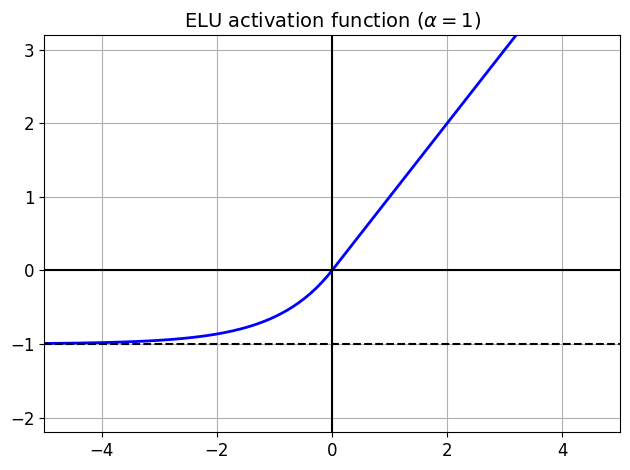

In [20]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [21]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [22]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


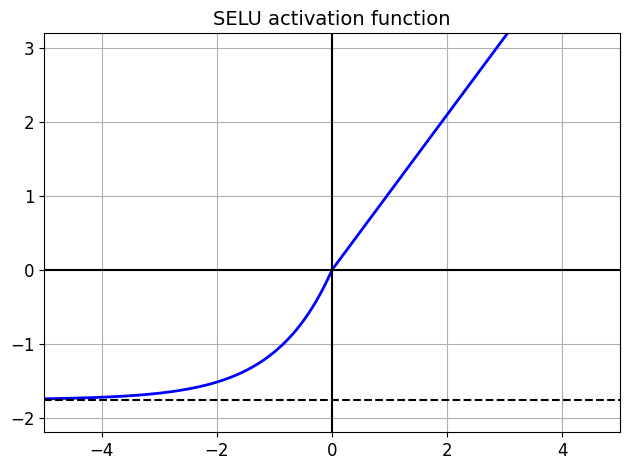

In [24]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [26]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Now let's train it.

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 28s 13ms/step - loss: 2.1143 - accuracy: 0.1629 - val_loss: 2.0485 - val_accuracy: 0.1754
Epoch 2/5
1719/1719 [==============================] - 23s 13ms/step - loss: 2.1252 - accuracy: 0.1700 - val_loss: 2.3019 - val_accuracy: 0.1058
Epoch 3/5
1719/1719 [==============================] - 22s 13ms/step - loss: 2.1629 - accuracy: 0.1904 - val_loss: 2.0890 - val_accuracy: 0.2064
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 2.1127 - accuracy: 0.2101 - val_loss: 2.1084 - val_accuracy: 0.1900
Epoch 5/5
1719/1719 [==============================] - 22s 13ms/step - loss: 2.0961 - accuracy: 0.2164 - val_loss: 2.0724 - val_accuracy: 0.2252


Now look at what happens if we try to use the ReLU activation function instead:

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 26s 12ms/step - loss: nan - accuracy: 0.2072 - val_loss: nan - val_accuracy: 0.0914
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 4/5
1719/1719 [==============================] - 21s 12ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.0914


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [35]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [36]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 1.5955 - accuracy: 0.8127 - val_loss: 0.7061 - val_accuracy: 0.8402
Epoch 2/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7191 - accuracy: 0.8286 - val_loss: 0.6890 - val_accuracy: 0.8334


In [37]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 1.6210 - accuracy: 0.8134 - val_loss: 0.7095 - val_accuracy: 0.8394
Epoch 2/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7203 - accuracy: 0.8283 - val_loss: 0.6966 - val_accuracy: 0.8328


## Dropout

In [38]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5704 - accuracy: 0.8032 - val_loss: 0.3666 - val_accuracy: 0.8656
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4236 - accuracy: 0.8446 - val_loss: 0.3422 - val_accuracy: 0.8736


## MC Dropout

In [39]:
tf.random.set_seed(42)
np.random.seed(42)

In [40]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [41]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 72ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.2 , 0.  , 0.75]],
      dtype=float32)

In [42]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.49, 0.  , 0.46]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.52, 0.  , 0.4 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.04, 0.  , 0.45]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.14, 0.  , 0.65]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.62, 0.  , 0.35]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.13, 0.  , 0.71]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.26, 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.13, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.64, 0.  , 0.13, 0.  , 0.23]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.47, 0.  , 0.24, 0.  , 0.29]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.04, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.1 , 0.  , 0

In [43]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.21, 0.  , 0.64]],
      dtype=float32)

In [44]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.18, 0.  , 0.23]],
      dtype=float32)

In [45]:
y_pred = np.argmax(y_proba, axis=1)

In [46]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8559

In [47]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

In [49]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [50]:
mc_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense_219 (Dense)           (None, 300)               235500    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_220 (Dense)           (None, 100)               30100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_221 (Dense)           (None, 10)               

In [51]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [52]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [53]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 16ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.2 , 0.  , 0.75]],
      dtype=float32)

## Max norm

In [54]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [55]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 0.4762 - accuracy: 0.8327 - val_loss: 0.3665 - val_accuracy: 0.8682
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3600 - accuracy: 0.8698 - val_loss: 0.3898 - val_accuracy: 0.8610


# Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [56]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [57]:
X_train_A.shape

(43986, 28, 28)

In [58]:
X_train_B.shape

(200, 28, 28)

In [59]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [60]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

In [62]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [63]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [64]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3568 - accuracy: 0.8715 - val_loss: 0.3024 - val_accuracy: 0.8929
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2648 - accuracy: 0.9075 - val_loss: 0.2526 - val_accuracy: 0.9128
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2433 - accuracy: 0.9136 - val_loss: 0.2384 - val_accuracy: 0.9163
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2273 - accuracy: 0.9192 - val_loss: 0.2262 - val_accuracy: 0.9200
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2150 - accuracy: 0.9236 - val_loss: 0.2313 - val_accuracy: 0.9188
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2065 - accuracy: 0.9269 - val_loss: 0.2251 - val_accuracy: 0.9168
Epoch 7/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.1986 - accuracy: 0.9285 - val_loss: 0.2348 - val_accuracy:

In [65]:
model_A.save("my_model_A.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [67]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [68]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 38ms/step - loss: 0.3978 - accuracy: 0.8000 - val_loss: 0.1465 - val_accuracy: 0.9696
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 0.0975 - accuracy: 0.9900 - val_loss: 0.1073 - val_accuracy: 0.9777
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0651 - accuracy: 0.9900 - val_loss: 0.0821 - val_accuracy: 0.9817
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0491 - accuracy: 0.9950 - val_loss: 0.0724 - val_accuracy: 0.9817
Epoch 5/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0388 - accuracy: 0.9950 - val_loss: 0.0667 - val_accuracy: 0.9817
Epoch 6/20
7/7 [==============================] - 0s 17ms/step - loss: 0.0319 - accuracy: 0.9950 - val_loss: 0.0631 - val_accuracy: 0.9858
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.0267 - accuracy: 0.9950 - val_loss: 0.0847 - val_accuracy: 0.9797
Epoch 8/20
7/7 [===========

In [69]:
model_B.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_232 (Dense)           (None, 300)               235500    
                                                                 
 dense_233 (Dense)           (None, 100)               30100     
                                                                 
 dense_234 (Dense)           (None, 50)                5050      
                                                                 
 dense_235 (Dense)           (None, 50)                2550      
                                                                 
 dense_236 (Dense)           (None, 50)                2550      
                                                                 
 dense_237 (Dense)           (None, 1)               

In [70]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [71]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [72]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [73]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 38ms/step - loss: 0.5387 - accuracy: 0.6950 - val_loss: 0.3435 - val_accuracy: 0.8377
Epoch 2/4
7/7 [==============================] - 0s 17ms/step - loss: 0.2562 - accuracy: 0.8900 - val_loss: 0.2098 - val_accuracy: 0.9300
Epoch 3/4
7/7 [==============================] - 0s 18ms/step - loss: 0.1616 - accuracy: 0.9700 - val_loss: 0.1544 - val_accuracy: 0.9615
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 0.1200 - accuracy: 0.9800 - val_loss: 0.1214 - val_accuracy: 0.9736


Epoch 1/16
7/7 [==============================] - 1s 39ms/step - loss: 0.0680 - accuracy: 0.9900 - val_loss: 0.0523 - val_accuracy: 0.9939
Epoch 2/16
7/7 [==============================] - 0s 17ms/step - loss: 0.0322 - accuracy: 1.0000 - val_loss: 0.0399 - val_accuracy: 0.9939
Epoch 3/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9939
Epoch 4/16
7/7 [==============================] - 0s 16ms/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.0309 - val_accuracy: 0.9939
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9939
Epoch 6/16
7/7 [==============================] - 0s 16ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.0275 - val_accuracy: 0.9939
Epoch 7/16
7/7 [==============================] - 0s 17ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9929
Epoch 8/16
7/7 [===========

So, what's the final verdict?

In [74]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0339 - accuracy: 0.9880


[0.03386424109339714, 0.9879999756813049]

In [75]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy: 0.9950


[0.017417754977941513, 0.9950000047683716]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4!

In [76]:
(100 - 96.95) / (100 - 99.25)

4.066666666666663